# Group Assignment 4

For the dataset shared in Assignment-2, build and perform 2 rounds of empirical tuning on the following collaborative filtering recommender systems:

1. **Collaborative Filtering Recommender System**
   
2. **Collaborative Filtering Recommender System Using Clustering**
   - Utilize user and day-of-week (dow) combinations.

3. **Collaborative Filtering Recommender System Using Matrix Factorization**
   - Focus on cases where `add_to_cart_order < 5`.

4. **Collaborative Filtering Recommender System Using Matrix Factorization**
   
---

## Evaluation Criteria

Evaluate all the models on the following metrics:
- MAP@5
- Precision for 1000 random users/dow combinations

### Generalization Methods
- Use both strong and weak generalization methods for evaluation.

### Additional Task
- Identify the top product recommended for the top 5 users who buy the most "Bananas".

# MECE Table

| Team Member   | Contribution                                                                                      |
|---------------|---------------------------------------------------------------------------------------------------|
| Kauthara Oyinkansola Yakubu | - Data preprocessing and initial exploratory data analysis (EDA)                                   |
|               | - Identify top 5 users who buy the most "Bananas"                                                |
|               |                                                                                                   |
| Subhash Pavan Chakravarthy Somarouthu | - Implement collaborative filtering recommender system                                       |
|               | - Perform first round of empirical tuning for this system                                          |
|               |                                                                                                   |
| Watapotha Kosinnage Chalithya Sangeeth Kumarasinghe | - Perform second round of empirical tuning for collaborative filtering system                |
|               | - Evaluate each of the models on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization |
|               |                                                                                                   |
| Abdullah Ifteqar Mohammed | - Implement collaborative filtering system using clustering with user and day-of-week combinations  |
|               | - Perform first round of empirical tuning for this clustered system                                 |
|               |                                                                                                   |
| Clifford Addison | - Perform second round of empirical tuning for clustered collaborative filtering system            |
|               | - Evaluate each of the models on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization |
|               |                                                                                                   |
| Shanaz Palakunnil Moosa | - Implement matrix factorization-based collaborative filtering system for add_to_cart_order < 5  |
|               | - Perform first round of empirical tuning for this system                                          |
|               |                                                                                                   |
| Mansi Jayeshbai Sutreja | - Perform second round of empirical tuning for matrix factorization system (add_to_cart_order < 5)|
|               | - Proper documentation, ensuring everyone's work is running sequentially and all tasks are completed—submission of Assignment. |
|               |                                                                                                   |
| Aparna Jayakumar Resmi | - Implement general matrix factorization-based collaborative filtering system                      |
|               | - Perform first round of empirical tuning for this system                                          |
|               |                                                                                                   |
| Obianuju Nonyerem Anuma | - Perform second round of empirical tuning for general matrix factorization system                 |
|               | - Evaluate each of the models on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization |
|               |                                                                                                   |
| Saurav Risal | - Identify top product recommended for the top 5 "Banana" buyers across all models                |
|               | - Evaluate this system on MAP@5 and Precision for 1000 random users/user, and dow combinations using strong and weak generalization for  matrix factorization-based collaborative filtering system for add_to_cart_order < 5  |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt#For visualizations
import itertools
from scipy import stats
from sklearn.impute import KNNImputer, SimpleImputer#for handling missing data



In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Loading the initial datasets
aisles_retail = pd.read_csv('/content/aisles.csv')
departments_retail = pd.read_csv('/content/departments.csv')
products_retail = pd.read_csv('/content/products.csv')
orders_df = pd.read_csv('/content/orders.csv')
order_products_retail = pd.read_csv('/content/order_products.csv')


print(f"aisles_retail shape: {aisles_retail.shape}")
print(f"departments_retail shape: {departments_retail.shape}")
print(f"products_retail shape: {products_retail.shape}")
print(f"orders_df shape: {orders_df.shape}")
print(f"order_products_retail shape: {order_products_retail.shape}")

aisles_retail shape: (134, 2)
departments_retail shape: (21, 2)
products_retail shape: (49688, 4)
orders_df shape: (3421083, 7)
order_products_retail shape: (32434489, 4)


In [4]:
# Join products with aisles and departments
merged_products = products_retail.merge(aisles_retail, on='aisle_id', how='left').merge(departments_retail, on='department_id', how='left')

print(f"merged_products shape: {merged_products.shape}")

merged_products shape: (49688, 6)


In [6]:
# Sampling order_products_retail
sample_fraction = 0.01  # 1% of the order_products dataset
order_products_sample = order_products_retail.sample(frac=sample_fraction, random_state=42)

In [7]:
print(f"order_products_sample shape: {order_products_sample.shape}")

order_products_sample shape: (324345, 4)


In [8]:
# Prepare for chunked processing
chunk_size = 1000000
result_chunks = []


In [9]:
# Processing order_products_sample in chunks
for chunk in pd.read_csv('/content/order_products.csv', chunksize=chunk_size):
    # Merge chunk with merged_products
    chunk_with_products = chunk.merge(merged_products, on='product_id', how='left')

    # Merge with orders_df to keep only relevant orders
    merged_chunk = orders_df.merge(chunk_with_products, on='order_id', how='inner')

    # Append the result to our list
    result_chunks.append(merged_chunk)

# Concatenate all the chunks
retail_dataset = pd.concat(result_chunks, ignore_index=True)

print(f"Final retail_dataset shape: {retail_dataset.shape}")

Final retail_dataset shape: (32434489, 15)


In [10]:
retail_dataset.shape

(32434489, 15)

In [11]:
retail_dataset.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,94891,4,prior,4,5,13,15.0,22199,1,0,Extra-Dry Cava,134,5,specialty wines champagnes,alcohol
1,94891,4,prior,4,5,13,15.0,25146,2,0,Original Orange Juice,31,7,refrigerated,beverages
2,23391,7,prior,17,0,10,28.0,13198,1,1,85% Lean Ground Beef,122,12,meat counter,meat seafood
3,23391,7,prior,17,0,10,28.0,42803,2,1,Organic Apple Slices,50,19,fruit vegetable snacks,snacks
4,23391,7,prior,17,0,10,28.0,8277,3,1,Apple Honeycrisp Organic,24,4,fresh fruits,produce


In [12]:
retail_dataset.tail()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
32434484,3412250,206208,prior,29,4,18,4.0,14467,8,1,Sweet Baguette,112,3,bread,bakery
32434485,3412250,206208,prior,29,4,18,4.0,23644,9,1,Sharp Cheddar Thick Slices Cheese,21,16,packaged cheese,dairy eggs
32434486,3412250,206208,prior,29,4,18,4.0,21461,10,0,Triple Creme Goat Brie,21,16,packaged cheese,dairy eggs
32434487,3412250,206208,prior,29,4,18,4.0,31506,11,1,Extra Virgin Olive Oil,19,13,oils vinegars,pantry
32434488,3412250,206208,prior,29,4,18,4.0,31404,12,1,Vanilla Yoghurt,120,16,yogurt,dairy eggs


# Sampling 1 % of the dataset because of its large

In [13]:
sample_size = int(len(retail_dataset) * 0.01)  # Calculate 1% of the dataset size
retail_dataset_sample = retail_dataset.sample(n=sample_size, random_state=42).drop_duplicates()

# User-Level Analysis

In [14]:
# User-Level Analysis
user_analysis = retail_dataset_sample.groupby('user_id').agg(
    total_orders=('order_id', 'nunique'),
    total_products=('product_id', 'nunique'),
    first_order_number=('order_number', 'min'),
    last_order_number=('order_number', 'max')
).reset_index()

#Product-Popularity Analysis

In [15]:
# Product Popularity Analysis
product_popularity = retail_dataset_sample.groupby('product_id').agg(
    product_name=('product_name', 'first'),  # Get the product name
    popularity_score=('order_id', 'nunique')  # Count unique orders for each product
).reset_index()

# Basket-combination Analysis

In [16]:
from itertools import combinations

In [17]:
# Basket Analysis

# Creating a basket for each order
basket_analysis = retail_dataset_sample.groupby(['order_id', 'product_id']).size().reset_index(name='count')

# Creating  a basket of products for each order
basket = basket_analysis.groupby('order_id')['product_id'].apply(list).reset_index()

In [18]:
# Function to create product combinations
def create_combinations(row):
    return list(combinations(row['product_id'], 2))

# Create combinations for each basket
basket['combinations'] = basket.apply(create_combinations, axis=1)

# Explode the combinations into separate rows
basket_exploded = basket.explode('combinations')

# Count the frequency of each combination
basket_combination_counts = basket_exploded.groupby('combinations').size().reset_index(name='count')

# Convert combinations to separate columns for easier merging
basket_combination_counts[['product_1', 'product_2']] = pd.DataFrame(basket_combination_counts['combinations'].tolist(), index=basket_combination_counts.index)


# User-Order-Product Analysis

In [19]:
#  User-Order-Product Analysis

# Grouping by user_id, product_id, and order_id to ensure there is no duplicate
groupby_columns = ['user_id', 'product_id', 'order_id']

# Aggregate the data to create a user-item combination interaction
updated_retail = retail_dataset_sample.groupby(groupby_columns).agg({
    'add_to_cart_order': 'min',
    'reordered': 'max',
    'order_number': 'first',
    'order_dow': 'first',
    'order_hour_of_day': 'first',
    'days_since_prior_order': 'first',
    'product_name': 'first',
    'aisle_id': 'first',
    'department_id': 'first',
    'aisle': 'first',
    'department': 'first'
}).reset_index()

# Add new columns for additional information
updated_retail['interaction_count'] = updated_retail.groupby(['user_id', 'product_id'])['order_id'].transform('count')
updated_retail['total_orders'] = updated_retail.groupby('user_id')['order_id'].transform('nunique')
updated_retail['product_order_rate'] = updated_retail['interaction_count'] / updated_retail['total_orders']

# USER-ITEM INTERACTION COMBINATION ANALYSIS BY THEIR KEY (`user_id`, `product_id`  and `order_id` ) To avoid duplicate.


**Goal:**   To create a unique representation of user-item interactions based on specific keys: `user_id`, `product_id`, `and order_id`. Doing this ensures that there are no duplicate entries for the same user- items(product and otder) combination.

  
* `add_to_cart_order:` 'min': This finds the minimum value of add_to_cart_order within each group, which may represent the earliest position in the cart for that product.

* `reordered`: 'max': This takes the maximum value of reordered, indicating whether the product was reordered at least once (1 for yes, 0 for no).

* `order_number`: 'first': This retrieves the first order number associated with that user-item combination.

*  `order_dow`: 'first': This gets the first day of the week for the order.

*  `order_hour_of_day`: 'first': This captures the first hour of the day when the order was placed.


* `days_since_prior_order`: 'first': This takes the first occurrence of days since the prior order.


* `product_name`: 'first', `aisle_id`: 'first', `department_id`: 'first', `aisle`: 'first', `department`: 'first': These retrieve the first values of the respective columns, providing consistent identifiers for the product and its attributes.





# Additional columns added:  Added three new columns to the dataset after grouping:

a) **interaction_count:**This column counts how many times each user-product combination appears in the dataset. It helps identify frequently purchased products for each user.

b) **total_orders:** This column counts the unique orders for each user. It gives an idea of how active each user is on the platform.

c) **product_order_rate:**  This is calculated as interaction_count / total_orders. It represents the proportion of a user's orders that include a specific product, indicating how frequently a user buys a particular product relative to their overall purchasing behavior.

In [20]:
# Merging User-Level Metrics with User-Order-Product Data
final_retail_data = updated_retail.merge(user_analysis, on='user_id', how='left', suffixes=('', '_user'))

In [21]:
# Merging Product Popularity Data
final_retail_data = final_retail_data.merge(product_popularity, on='product_id', how='left')

In [22]:
final_retail_data.shape

(324344, 23)

In [23]:
final_retail_data.head()

,user_id,product_id,order_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name_x,aisle_id,department_id,aisle,department,interaction_count,total_orders,product_order_rate,total_orders_user,total_products,first_order_number,last_order_number,product_name_y,popularity_score
0,2,12000,1718559,3,1,9,2,9,8.0,Baked Organic Sea Salt Crunchy Pea Snack,72,13,condiments,pantry,1,3,0.333333,3,3,5,11,Baked Organic Sea Salt Crunchy Pea Snack,19
1,2,19156,1402090,4,1,11,1,10,30.0,Fat Free Blueberry Yogurt,120,16,yogurt,dairy eggs,1,3,0.333333,3,3,5,11,Fat Free Blueberry Yogurt,71
2,2,38656,1673511,4,0,5,3,11,8.0,Gluten Free Peanut Butter Dark Chocolate Chewy With a Crunch Granola Bars,3,19,energy granola bars,snacks,1,3,0.333333,3,3,5,11,Gluten Free Peanut Butter Dark Chocolate Chewy With a Crunch Granola Bars,61
3,3,16965,2037211,4,0,4,2,18,20.0,Chocolate Ice Cream,37,1,ice cream ice,frozen,1,2,0.500000,2,2,4,7,Chocolate Ice Cream,141
4,3,39190,1839752,1,1,7,0,15,7.0,Vanilla Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs,1,2,0.500000,2,2,4,7,Vanilla Unsweetened Almond Milk,118


# Checking for any data Inconsistencies

In [28]:
# 1. Checking for any null values resulting from the merge
print("\nNull value counts:")
print(final_retail_data.isnull().sum())


Null value counts:
user_id                       0
product_id                    0
order_id                      0
add_to_cart_order             0
reordered                     0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    20752
product_name_x                0
aisle_id                      0
department_id                 0
aisle                         0
department                    0
interaction_count             0
total_orders                  0
product_order_rate            0
total_orders_user             0
total_products                0
first_order_number            0
last_order_number             0
product_name_y                0
popularity_score              0
dtype: int64


In [29]:
# 2. Checking for unique values
for i in updated_retail.columns:
    # Check if the column exists in final_retail_data before accessing it
    if i in final_retail_data.columns:
        print(final_retail_data[i].value_counts())
    else:
        print(f"Column '{i}' not found in final_retail_data")

user_id
164055    43
201268    41
129928    38
60694     36
5360      34
          ..
112        1
114        1
118        1
122        1
206111     1
Name: count, Length: 118762, dtype: int64
product_id
24852    4596
13176    3836
21137    2581
21903    2440
47209    2161
         ... 
8494        1
44499       1
5494        1
11813       1
45025       1
Name: count, Length: 25532, dtype: int64
order_id
1793836    5
586486     5
2823573    5
743011     5
2304048    4
          ..
3128903    1
779122     1
925012     1
2129080    1
3258910    1
Name: count, Length: 301996, dtype: int64
add_to_cart_order
1      31914
2      30612
3      28645
4      26568
5      24497
       ...  
79         1
122        1
102        1
80         1
88         1
Name: count, Length: 93, dtype: int64
reordered
1    191441
0    132903
Name: count, dtype: int64
order_number
1     20752
3     20432
2     20364
4     18048
5     16332
      ...  
96      146
99      132
92      130
97      130
98      123
Nam

In [24]:
# 3. Checking for negative values in numeric columns
numeric_columns = final_retail_data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    negative_count = (final_retail_data[col] < 0).sum()
    if negative_count > 0:
        print(f"  Column '{col}' has {negative_count} negative values.")
print("Negative value check completed.")

Negative value check completed.


In [26]:
# 4. Checking for out-of-range values
if 'order_dow' in final_retail_data.columns:
    invalid_dow = (final_retail_data['order_dow'] < 0) | (final_retail_data['order_dow'] > 6)
    print(f"  Invalid day of week values: {invalid_dow.sum()}")

if 'order_hour_of_day' in final_retail_data.columns:
    invalid_hour = (final_retail_data['order_hour_of_day'] < 0) | (final_retail_data['order_hour_of_day'] > 23)
    print(f"  Invalid hour of day values: {invalid_hour.sum()}")


  Invalid day of week values: 0
  Invalid hour of day values: 0


In [28]:
# 5.  Checking for inconsistent categorical data
categorical_columns = final_retail_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = final_retail_data[col].nunique()
    print(f"  Column '{col}' has {unique_values} unique values.")

    if unique_values > 100:  # Adjust this threshold as needed
        print(f"  Warning: High number of unique values in '{col}'. May need further investigation.")
        print(f"  Top 10 most common values in '{col}':")
        print(final_retail_data[col].value_counts().head(10))
    else:
        print(f"  All unique values in '{col}':")
        print(final_retail_data[col].unique())

    print()


  Column 'product_name_x' has 25532 unique values.
  Top 10 most common values in 'product_name_x':
product_name_x
Banana                    4596
Bag of Organic Bananas    3836
Organic Strawberries      2581
Organic Baby Spinach      2440
Organic Hass Avocado      2161
Organic Avocado           1797
Large Lemon               1581
Strawberries              1461
Organic Whole Milk        1378
Limes                     1356
Name: count, dtype: int64

  Column 'aisle' has 134 unique values.
  Top 10 most common values in 'aisle':
aisle
fresh fruits                     36336
fresh vegetables                 33957
packaged vegetables fruits       17692
yogurt                           14468
packaged cheese                   9936
milk                              9043
water seltzer sparkling water     8365
chips pretzels                    7329
soy lactosefree                   6501
bread                             5867
Name: count, dtype: int64

  Column 'department' has 21 unique values.
 

In [29]:
# 6. Checking for unique value in department column

unique_departments = final_retail_data['department'].nunique()
print(f"  The 'department' column has {unique_departments} unique values.")

# Get value counts and sort by frequency
dept_counts = final_retail_data['department'].value_counts().sort_values(ascending=False)

print("\n  All departments and their frequencies:")
for dept, count in dept_counts.items():
    print(f"  {dept}: {count}")

  The 'department' column has 21 unique values.

  All departments and their frequencies:
  produce: 94490
  dairy eggs: 54366
  snacks: 29032
  beverages: 26946
  frozen: 22230
  pantry: 18855
  bakery: 11699
  canned goods: 10645
  deli: 10572
  dry goods pasta: 8696
  household: 7331
  breakfast: 7138
  meat seafood: 6963
  personal care: 4462
  babies: 4236
  international: 2700
  alcohol: 1551
  pets: 1017
  missing: 682
  other: 370
  bulk: 363


In [30]:
# Checking for null value in 'department' column
null_count = final_retail_data['department'].isnull().sum()
total_records = len(final_retail_data)
null_percentage = (null_count / total_records) * 100

print(f"  Null values in 'department' column: {null_count} ({null_percentage:.2f}%)")

  Null values in 'department' column: 0 (0.00%)


In [31]:
# Checking categorical data for 'aisle' colum
print(" Checking categorical data for 'aisle' column...")

# Checking for null values
null_count = final_retail_data['aisle'].isnull().sum()
total_records = len(final_retail_data)
null_percentage = (null_count / total_records) * 100

print(f"  Null values in 'aisle' column: {null_count} ({null_percentage:.2f}%)")

# Count unique values (excluding nulls)
unique_aisles = final_retail_data['aisle'].nunique()
print(f"  The 'aisle' column has {unique_aisles} unique values (excluding nulls).")

# Get value counts and sort by frequency (this will automatically exclude nulls)
aisle_counts = final_retail_data['aisle'].value_counts().sort_values(ascending=False)

print("\n  Top 20 aisles and their frequencies:")
for aisle, count in aisle_counts.head(20).items():
    print(f"  {aisle}: {count}")

# Calculate and display percentages for top 20
print("\n  Top 20 aisles by percentage (including nulls in total count):")
for aisle, count in aisle_counts.head(20).items():
    percentage = (count / total_records) * 100
    print(f"  {aisle}: {percentage:.2f}%")

# If there are null values, add them to the percentage list
if null_count > 0:
    print(f"  Null: {null_percentage:.2f}%")

print(f"\n  Total number of aisles: {len(aisle_counts)}")

print("\nAisle data check completed.")

 Checking categorical data for 'aisle' column...
  Null values in 'aisle' column: 0 (0.00%)
  The 'aisle' column has 134 unique values (excluding nulls).

  Top 20 aisles and their frequencies:
  fresh fruits: 36336
  fresh vegetables: 33957
  packaged vegetables fruits: 17692
  yogurt: 14468
  packaged cheese: 9936
  milk: 9043
  water seltzer sparkling water: 8365
  chips pretzels: 7329
  soy lactosefree: 6501
  bread: 5867
  refrigerated: 5757
  frozen produce: 5197
  ice cream ice: 4970
  energy granola bars: 4584
  crackers: 4568
  eggs: 4493
  lunch meat: 3968
  cereal: 3836
  baby food formula: 3819
  fresh herbs: 3762

  Top 20 aisles by percentage (including nulls in total count):
  fresh fruits: 11.20%
  fresh vegetables: 10.47%
  packaged vegetables fruits: 5.45%
  yogurt: 4.46%
  packaged cheese: 3.06%
  milk: 2.79%
  water seltzer sparkling water: 2.58%
  chips pretzels: 2.26%
  soy lactosefree: 2.00%
  bread: 1.81%
  refrigerated: 1.77%
  frozen produce: 1.60%
  ice cream

In [56]:
# 7. Check for duplicate rows after grouping
duplicate_rows = final_retail_data.duplicated().sum()
print(f"  Number of duplicate rows after grouping: {duplicate_rows}")


  Number of duplicate rows after grouping: 0


In [34]:
# 8. Checking for inconsistencies in user ID or product IDs
user_order_counts = final_retail_data.groupby('user_id')['order_id'].nunique()
suspicious_users = user_order_counts[user_order_counts > 100]  # Adjust threshold as needed
if not suspicious_users.empty:
    print(f"  Users with suspiciously high number of orders: {len(suspicious_users)}")
    print("  Top 5 suspicious users:")
    print(suspicious_users.head())
else:
    print("  No users with suspiciously high number of orders found.")


  No users with suspiciously high number of orders found.


In [35]:
# 9. Check for missing values
missing_values = final_retail_data.isnull().sum()
print("  Missing values in each column:")
print(missing_values)


  Missing values in each column:
user_id                       0
product_id                    0
order_id                      0
add_to_cart_order             0
reordered                     0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    20752
product_name_x                0
aisle_id                      0
department_id                 0
aisle                         0
department                    0
interaction_count             0
total_orders                  0
product_order_rate            0
total_orders_user             0
total_products                0
first_order_number            0
last_order_number             0
product_name_y                0
popularity_score              0
dtype: int64


In [36]:
# 10. Check for outliers in numeric columns (using IQR method)
for col in numeric_columns:
    Q1 = final_retail_data[col].quantile(0.25)
    Q3 = final_retail_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((final_retail_data[col] < lower_bound) | (final_retail_data[col] > upper_bound)).sum()
    if outliers > 0:
        print(f"  Column '{col}' has {outliers} potential outliers.")


  Column 'add_to_cart_order' has 13585 potential outliers.
  Column 'order_number' has 17795 potential outliers.
  Column 'order_hour_of_day' has 2085 potential outliers.
  Column 'interaction_count' has 19529 potential outliers.
  Column 'total_orders' has 15408 potential outliers.
  Column 'total_orders_user' has 15408 potential outliers.
  Column 'total_products' has 9828 potential outliers.
  Column 'first_order_number' has 19706 potential outliers.
  Column 'last_order_number' has 9665 potential outliers.
  Column 'popularity_score' has 45299 potential outliers.


In [37]:
for col in ['add_to_cart_order', 'order_number', 'order_hour_of_day', 'interaction_count', 'total_orders', 'product_order_rate']:
    Q1 = final_retail_data[col].quantile(0.25)
    Q3 = final_retail_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = final_retail_data[(final_retail_data[col] < lower_bound) | (final_retail_data[col] > upper_bound)]
    print(f"\nOutliers in {col}:")
    print(outliers[col].describe())



Outliers in add_to_cart_order:
count    13585.000000
mean        30.179831
std          7.127073
min         24.000000
25%         25.000000
50%         28.000000
75%         33.000000
max        134.000000
Name: add_to_cart_order, dtype: float64

Outliers in order_number:
count    17795.000000
mean        68.427423
std         12.404372
min         53.000000
25%         58.000000
50%         65.000000
75%         77.000000
max         99.000000
Name: order_number, dtype: float64

Outliers in order_hour_of_day:
count    2085.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: order_hour_of_day, dtype: float64

Outliers in interaction_count:
count    19529.000000
mean         2.094065
std          0.321798
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: interaction_count, dtype: float64

Outliers in total_orders:
count    15408.000000
mean        15.72

In [41]:
final_retail_data.describe()

,user_id,product_id,order_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,interaction_count,total_orders,product_order_rate,total_orders_user,total_products,first_order_number,last_order_number,popularity_score
count,324344.000000,324344.000000,3.243440e+05,324344.000000,324344.000000,324344.000000,324344.000000,324344.000000,303592.000000,324344.000000,324344.000000,324344.000000,324344.000000,324344.000000,324344.000000,324344.000000,324344.000000,324344.000000,324344.000000
mean,102811.262231,25619.009339,1.710544e+06,8.359705,0.590241,17.146514,2.734433,13.441944,11.088451,71.243245,9.940357,1.065875,4.734060,0.402096,4.734060,4.956102,6.202378,28.037806,356.200411
std,59486.258559,14099.819570,9.869500e+05,7.137885,0.491790,17.532975,2.091351,4.234975,8.775463,38.208520,6.281199,0.271968,3.785539,0.309933,3.785539,3.966158,6.520599,24.056979,784.845845
min,2.000000,1.000000,9.000000e+00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.030303,1.000000,1.000000,1.000000,1.000000,1.000000
25%,51161.750000,13535.000000,8.562588e+05,3.000000,0.000000,5.000000,1.000000,10.000000,5.000000,31.000000,4.000000,1.000000,2.000000,0.166667,2.000000,2.000000,2.000000,9.000000,17.000000
50%,102431.000000,25407.000000,1.710151e+06,6.000000,1.000000,11.000000,3.000000,13.000000,8.000000,83.000000,9.000000,1.000000,4.000000,0.333333,4.000000,4.000000,4.000000,21.000000,68.000000
75%,154282.250000,38018.000000,2.561616e+06,11.000000,1.000000,24.000000,5.000000,16.000000,15.000000,107.000000,16.000000,1.000000,6.000000,0.500000,6.000000,7.000000,8.000000,41.000000,284.000000
max,206209.000000,49684.000000,3.421083e+06,134.000000,1.000000,99.000000,6.000000,23.000000,30.000000,134.000000,21.000000,5.000000,33.000000,1.000000,33.000000,37.000000,99.000000,99.000000,4596.000000


In [55]:
# 11. Check for inconsistencies between related columns
if 'reordered' in final_retail_data.columns and 'order_number' in final_retail_data.columns:
    inconsistent = ((final_retail_data['reordered'] == 1) & (final_retail_data['order_number'] == 1)).sum()
    if inconsistent > 0:
        print(f"  Inconsistency: {inconsistent} products marked as reordered in first order.")
    else:
        print("  No inconsistencies found between 'reordered' and 'order_number' columns.")
else:
    print("  'reordered' or 'order_number' column not found. Skipping this check.")



  No inconsistencies found between 'reordered' and 'order_number' columns.


# Visualization of Exploratory Data Analysis on the  Dataset


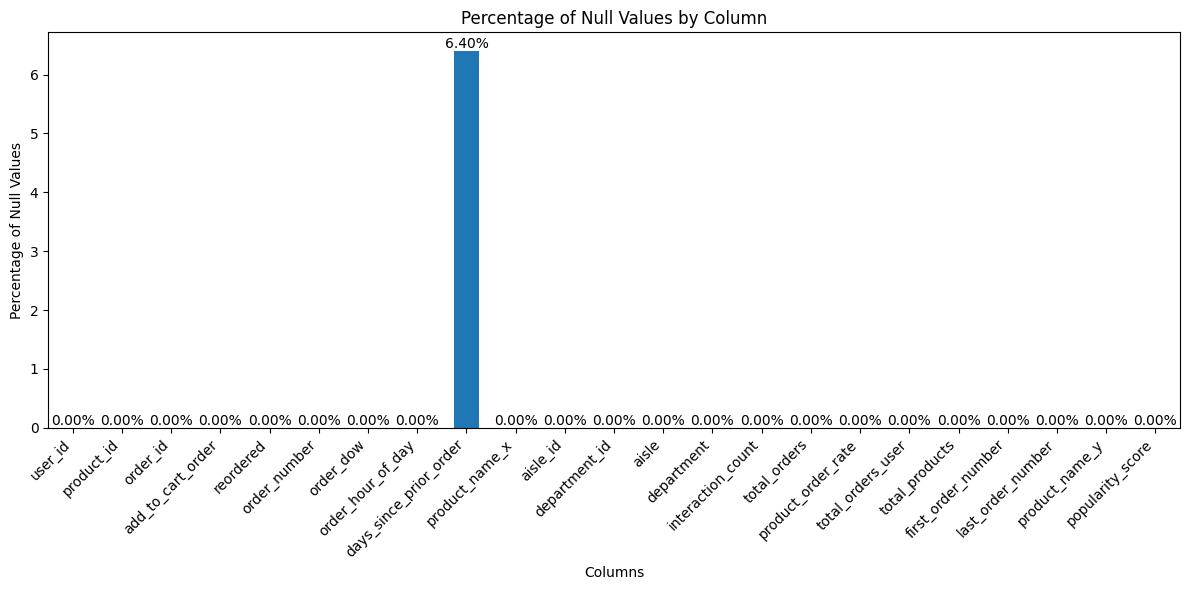

user_id                   0.000000
product_id                0.000000
order_id                  0.000000
add_to_cart_order         0.000000
reordered                 0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.398145
product_name_x            0.000000
aisle_id                  0.000000
department_id             0.000000
aisle                     0.000000
department                0.000000
interaction_count         0.000000
total_orders              0.000000
product_order_rate        0.000000
total_orders_user         0.000000
total_products            0.000000
first_order_number        0.000000
last_order_number         0.000000
product_name_y            0.000000
popularity_score          0.000000
dtype: float64


In [40]:
# Calculate percentage of null values for each column
null_percentages = final_retail_data.isnull().mean() * 100

plt.figure(figsize=(12, 6))
null_percentages.plot(kind='bar')
plt.title('Percentage of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adding percentage labels on top of each bar
for i, v in enumerate(null_percentages):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')

plt.show()

# Print the percentages
print(null_percentages)

# Correlation Map based  this colunm

**column:** 'interaction_count', 'total_orders', 'product_order_rate','popularity_score', 'days_since_prior_order', 'add_to_cart_order'


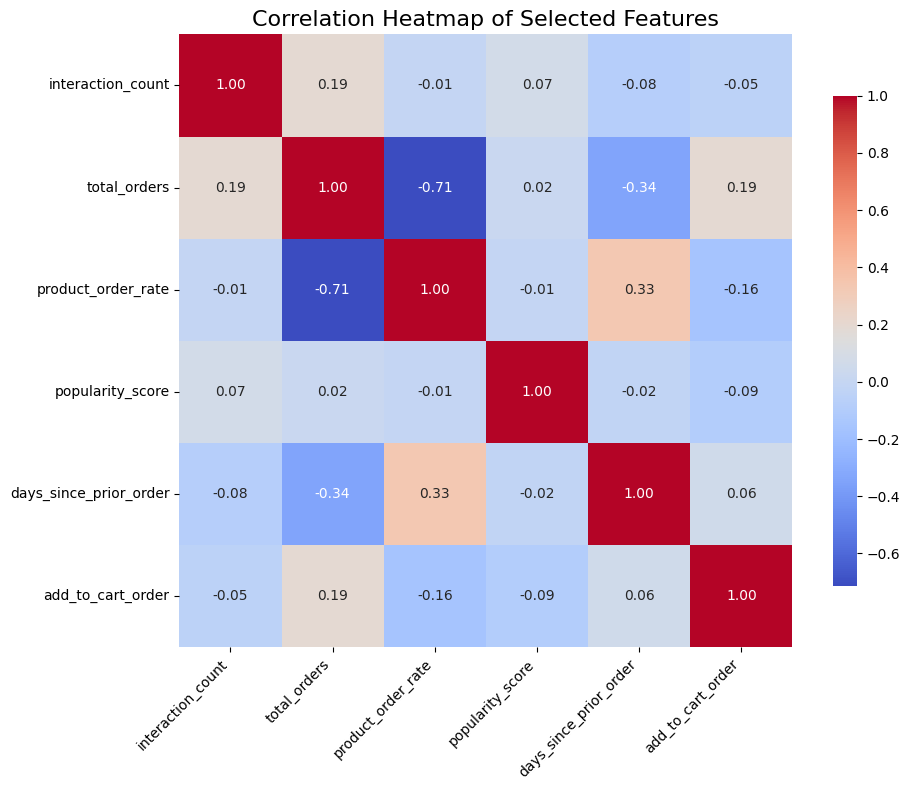

In [41]:
# Creating a subset of the DataFrame with selected numerical columns
subset = final_retail_data[['interaction_count', 'total_orders', 'product_order_rate',
                             'popularity_score', 'days_since_prior_order', 'add_to_cart_order']]

# Calculating the correlation matrix for the subset
correlation_matrix = subset.corr()

plt.figure(figsize=(10, 8))

# Creating a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap of Selected Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

#Orders Number *Analysis*

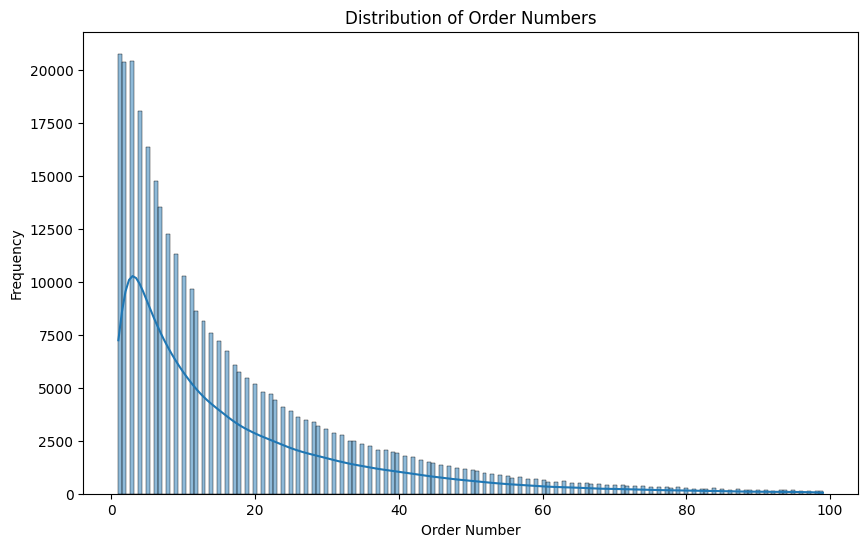

In [45]:
# Histogram of order_number
plt.figure(figsize=(10, 6))
sns.histplot(data=final_retail_data, x='order_number', kde=True)
plt.title('Distribution of Order Numbers')
plt.xlabel('Order Number')
plt.ylabel('Frequency')
plt.show()

# Visualizing Order frequency by day of week

**Sunday has the highest orders for the days of the week**

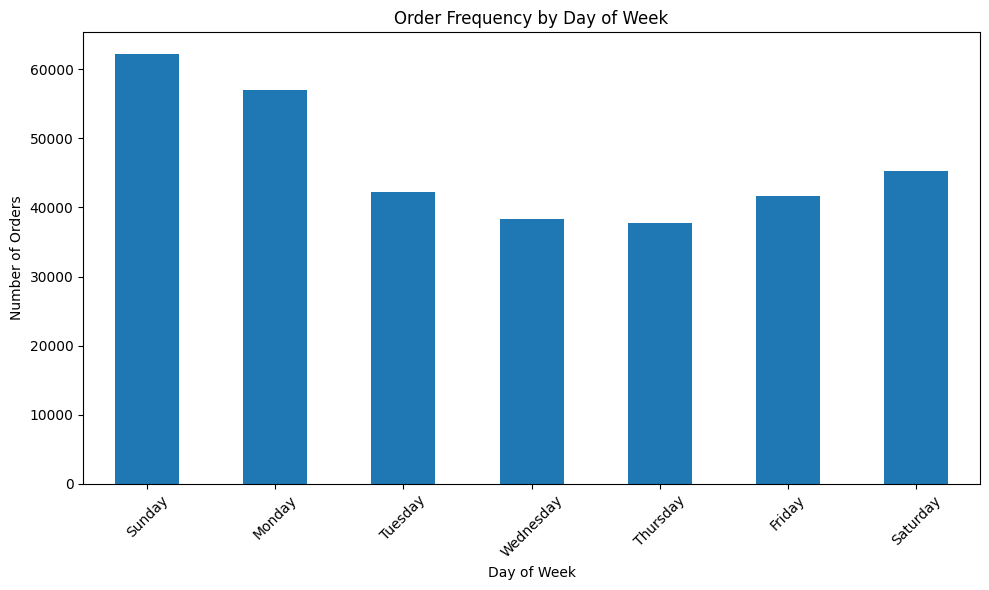

In [46]:
# Visualizing Order frequency by day of week

# Creating a dictionary to map numeric days to day names
day_order = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
             4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

# Count orders for each day and map to day names
day_counts = final_retail_data['order_dow'].value_counts().sort_index()
day_counts.index = day_counts.index.map(day_order)

plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar')
plt.title('Order Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Order hours visualization

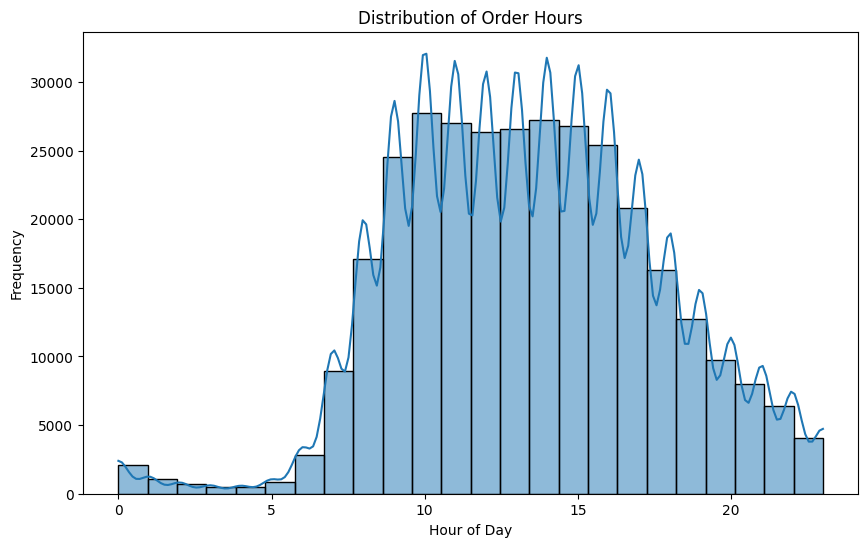

In [47]:
# Histogram of order_hour_of_day
plt.figure(figsize=(10, 6))
sns.histplot(data=final_retail_data, x='order_hour_of_day', kde=True, bins=24)
plt.title('Distribution of Order Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

# Product Popularity Analysis

How many times the product appeared in each user-product combination in the dataset. It helps identify frequently purchased products by each user in there purchase.

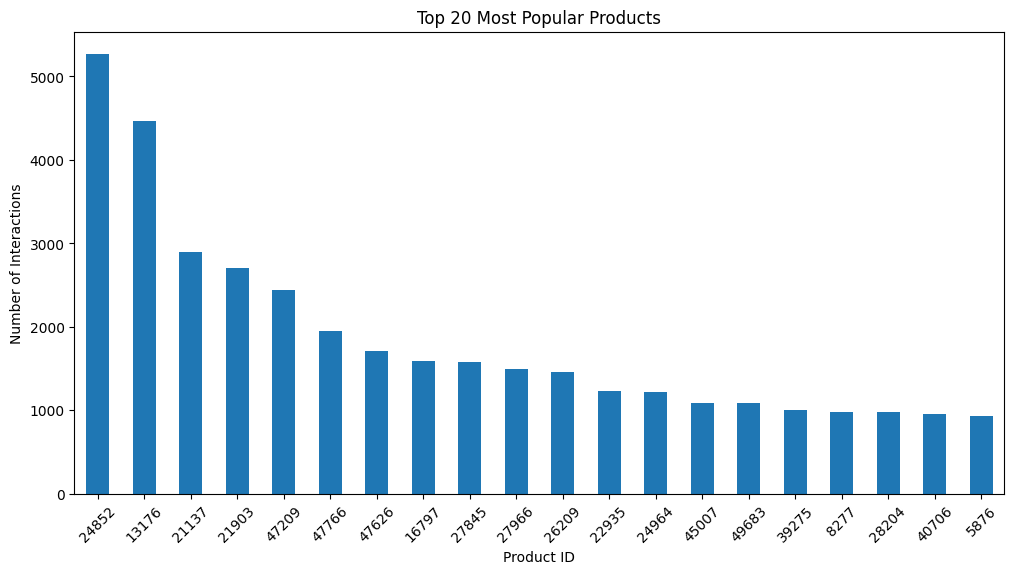

In [49]:
# Product popularity distribution by Product ID
product_popularity = final_retail_data.groupby('product_id')['interaction_count'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
product_popularity.head(20).plot(kind='bar')
plt.title('Top 20 Most Popular Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()

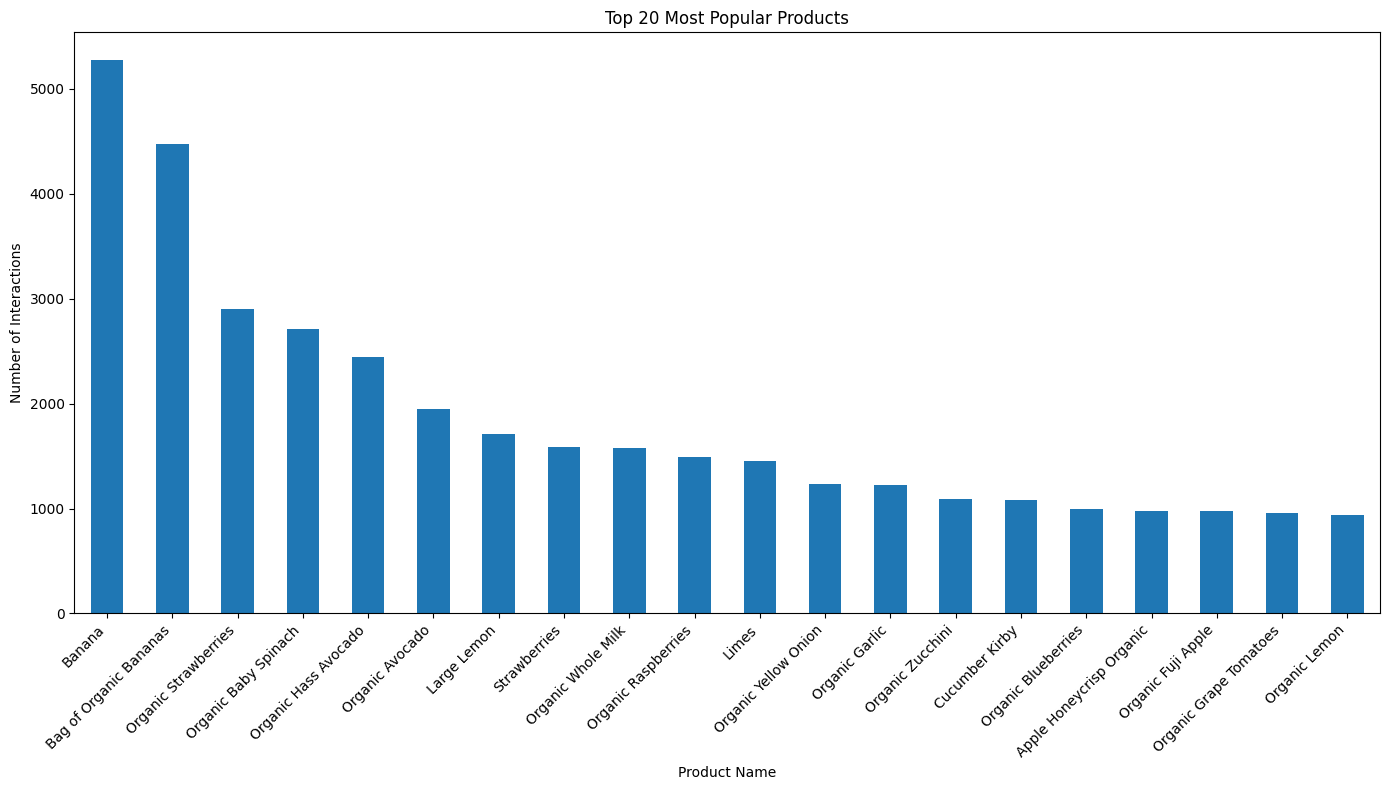

In [50]:
# Product popularity distribution by Product_name
product_popularity = final_retail_data.groupby('product_name_x')['interaction_count'].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 8))  # Increase the figure size
product_popularity.head(20).plot(kind='bar')

plt.title('Top 20 Most Popular Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Interactions')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

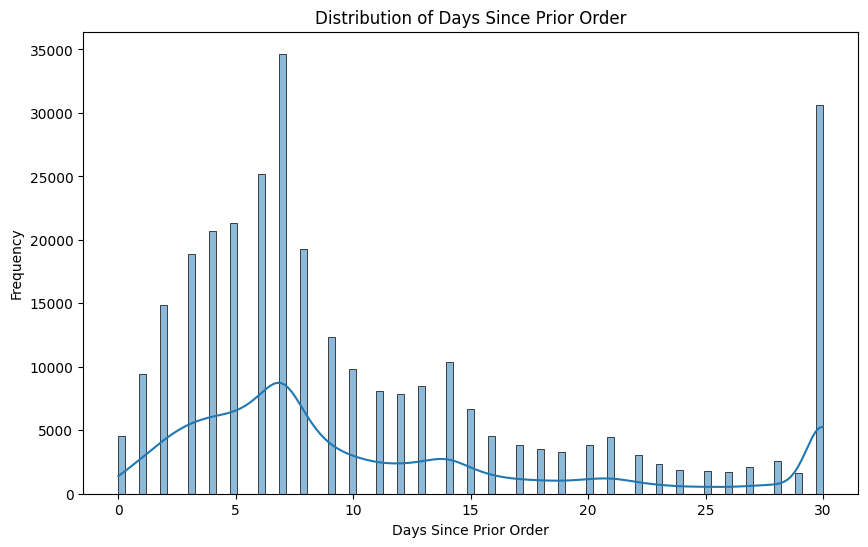

In [51]:
# Histogram of days_since_prior_order
plt.figure(figsize=(10, 6))
sns.histplot(data=final_retail_data, x='days_since_prior_order', kde=True)
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.show()

# Product Across Aisle Analysis

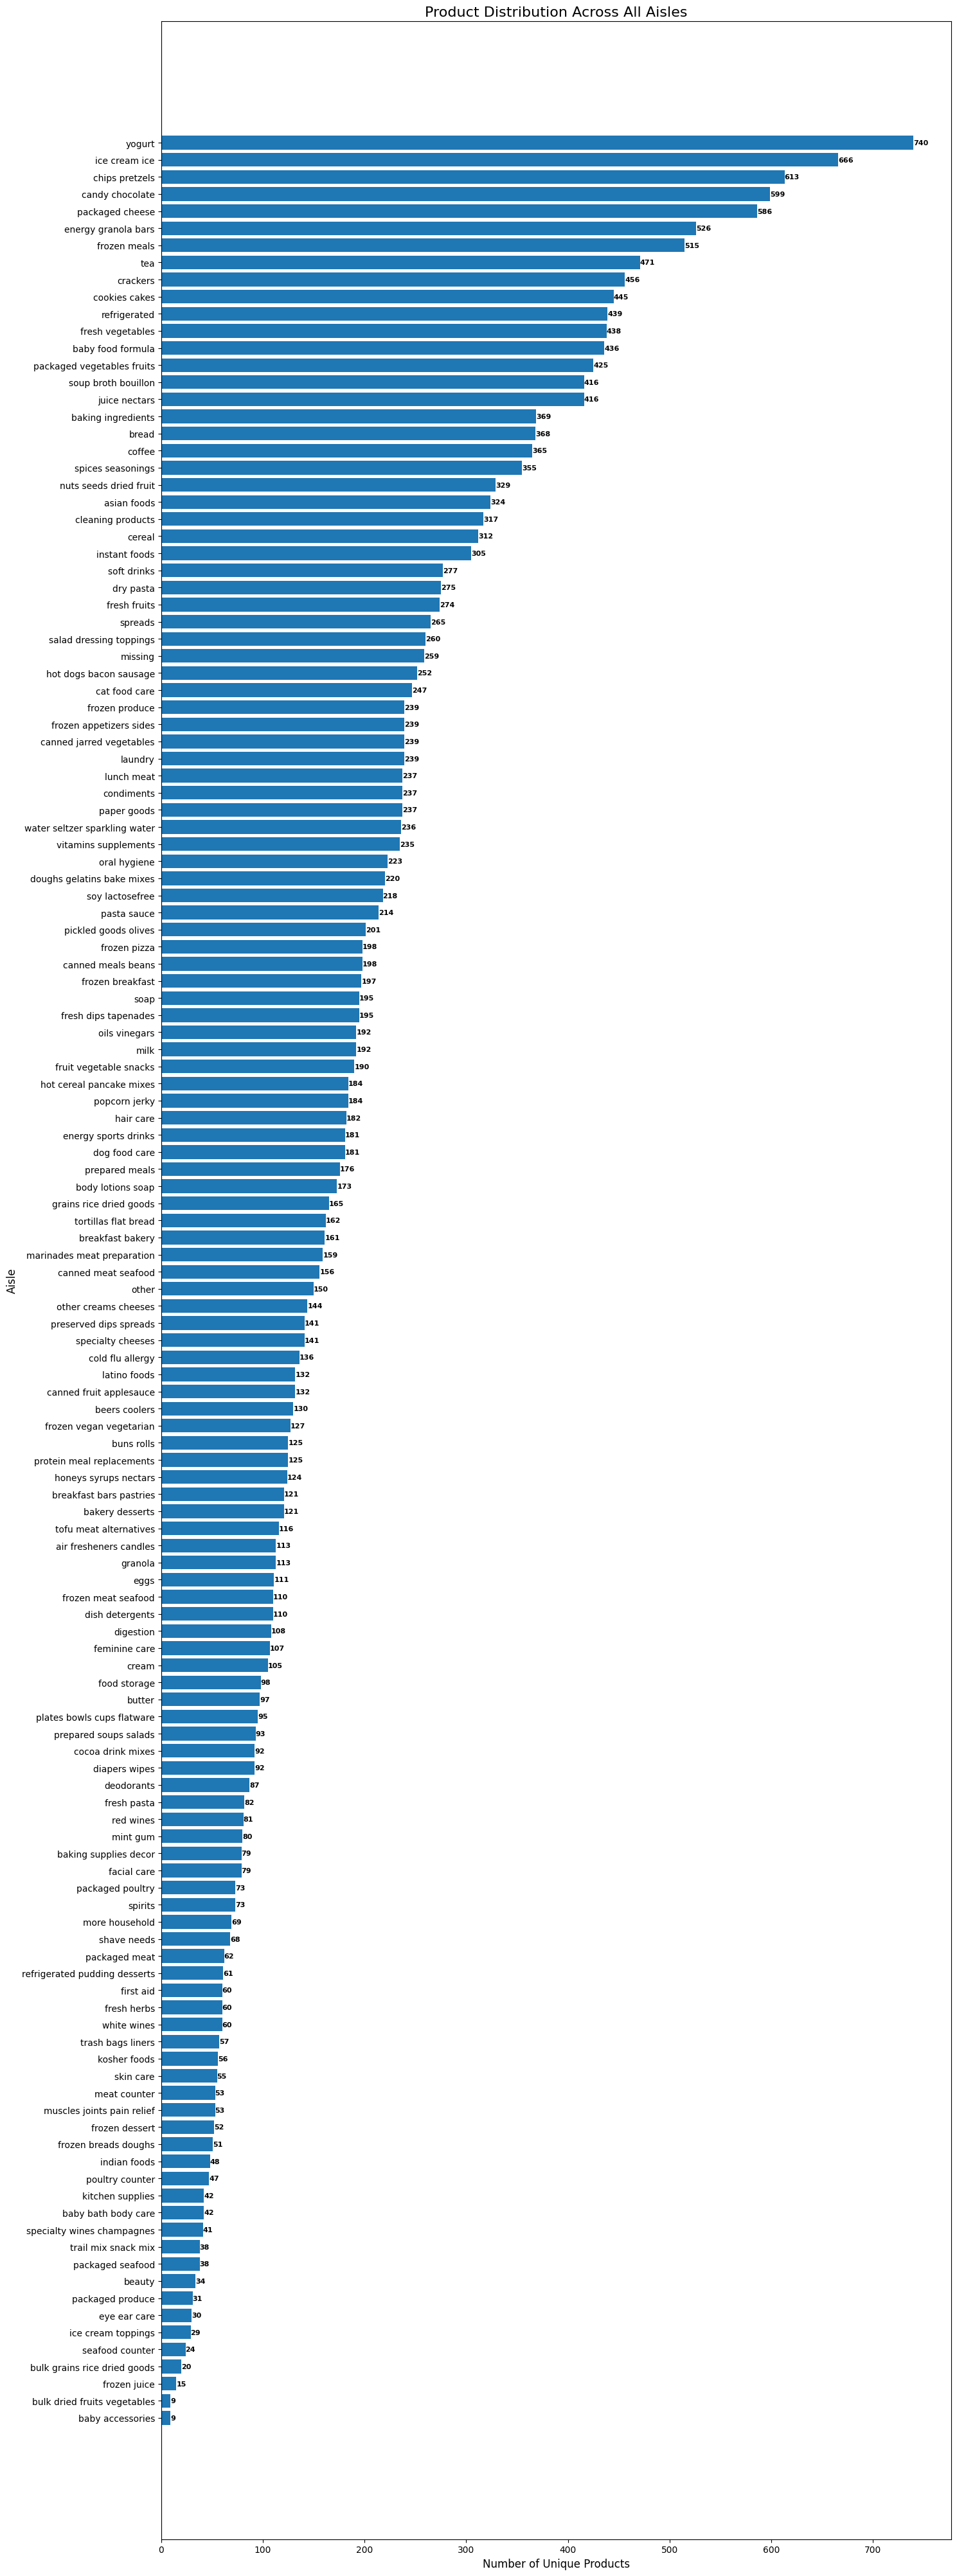

In [53]:
import matplotlib.pyplot as plt

# Group and sort the data
aisle_product_counts = final_retail_data.groupby('aisle')['product_id'].nunique().sort_values(ascending=True)

# Create the plot
plt.figure(figsize=(15, len(aisle_product_counts) * 0.3))
bars = plt.barh(aisle_product_counts.index, aisle_product_counts.values)

plt.title('Product Distribution Across All Aisles', fontsize=16)
plt.xlabel('Number of Unique Products', fontsize=12)
plt.ylabel('Aisle', fontsize=12)


plt.yticks(rotation=0)

# Adding value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}',
             ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# User-level Analysis and behaviour over Time

<Axes: title={'center': 'Top 10 Users by Total Orders'}, xlabel='user_id'>

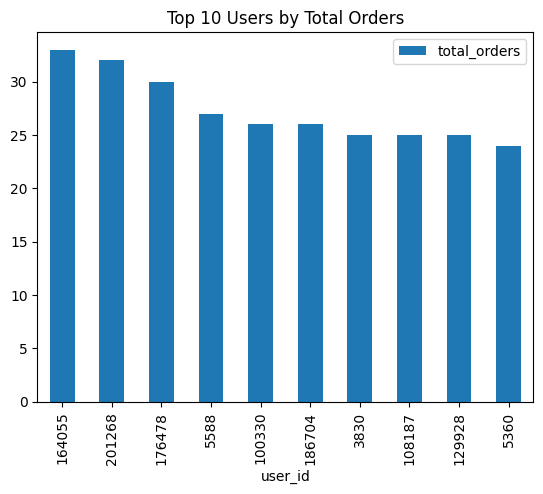

In [54]:
#Total orders by top 10 users
total_orders_per_user = final_retail_data.groupby('user_id')['order_id'].nunique().reset_index()
total_orders_per_user.columns = ['user_id', 'total_orders']
top_users = total_orders_per_user.sort_values(by='total_orders', ascending=False).head(10)
top_users.plot(kind='bar', x='user_id', y='total_orders', title='Top 10 Users by Total Orders')

<Axes: title={'center': 'Basket Size Distribution'}>

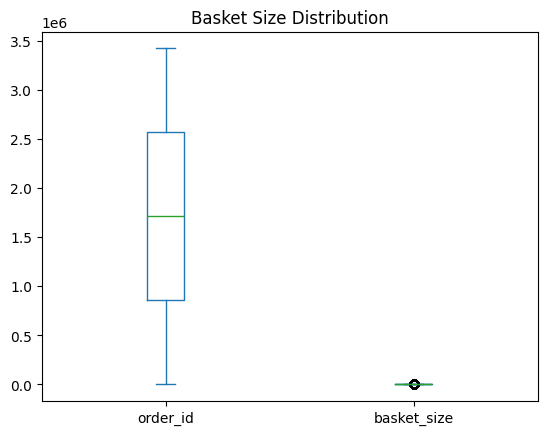

In [55]:
# Average Basket Size
basket_size = retail_dataset.groupby('order_id')['product_id'].count().reset_index()
basket_size.columns = ['order_id', 'basket_size']
basket_size.plot(kind='box', title='Basket Size Distribution')

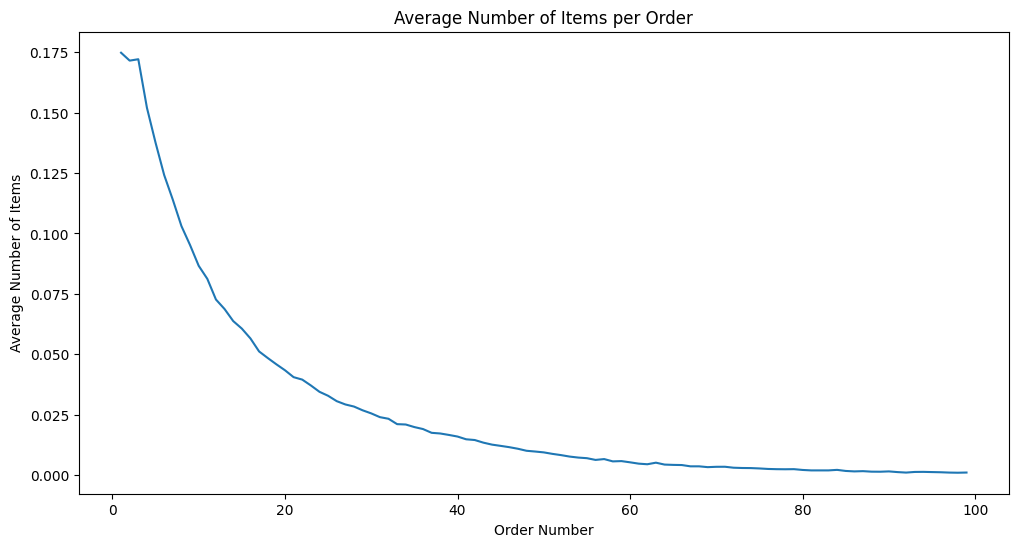

In [56]:
# User behavior over time
user_order_counts = final_retail_data.groupby(['user_id', 'order_number']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
user_order_counts.mean().plot()
plt.title('Average Number of Items per Order')
plt.xlabel('Order Number')
plt.ylabel('Average Number of Items')
plt.show()

# User item Interaction Analysis
--
Showing the top 30 users and the top 30 products, displaying how many interactions (e.g., purchases) each of the users has had with each product.

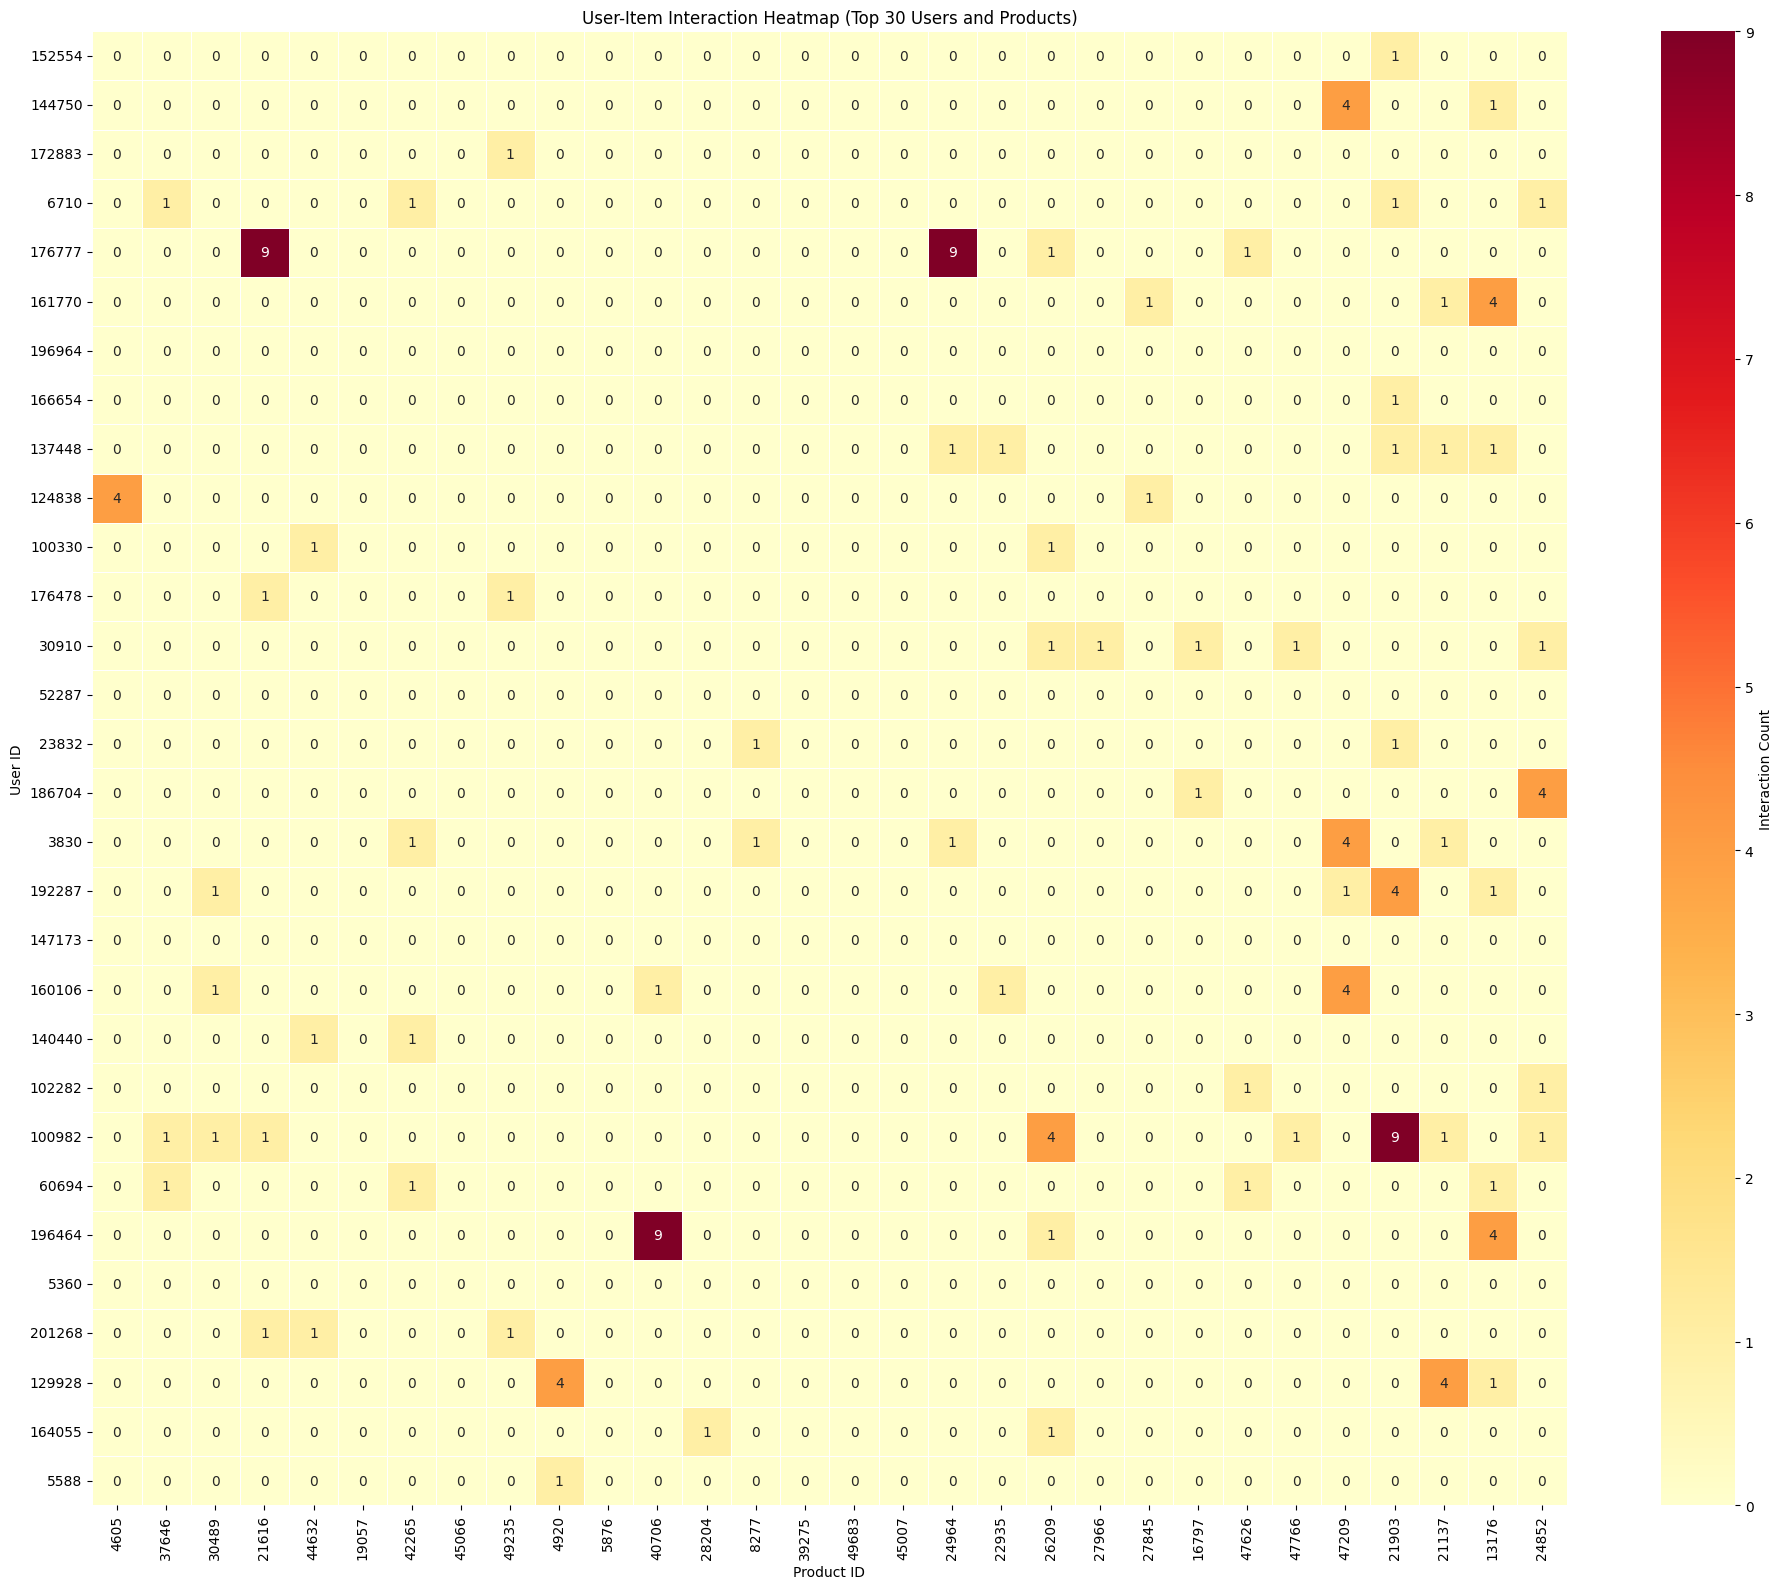

In [43]:
from scipy.sparse import csr_matrix

# Create sparse matrix directly from your
user_ids = final_retail_data['user_id'].astype('category').cat.codes
product_ids = final_retail_data['product_id'].astype('category').cat.codes
interaction_counts = final_retail_data['interaction_count']

sparse_matrix = csr_matrix((interaction_counts, (user_ids, product_ids)))

# Get top 30 users and products
N = 30
top_users = np.argsort(sparse_matrix.sum(axis=1).A1)[-N:]
top_products = np.argsort(sparse_matrix.sum(axis=0).A1)[-N:]

# Create dense matrix for top users/products
small_matrix = sparse_matrix[top_users, :][:, top_products].todense()

# Get original user and product IDs
original_user_ids = final_retail_data['user_id'].astype('category').cat.categories[top_users]
original_product_ids = final_retail_data['product_id'].astype('category').cat.categories[top_products]

# Plot
plt.figure(figsize=(20, 16))
sns.heatmap(small_matrix,
            cmap='YlOrRd',
            annot=True,
            fmt='d',
            cbar_kws={'label': 'Interaction Count'},
            linewidths=0.5,
            square=True,
            xticklabels=original_product_ids,
            yticklabels=original_user_ids)

plt.title(f'User-Item Interaction Heatmap (Top {N} Users and Products)')
plt.xlabel('Product ID')
plt.ylabel('User ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#Product Re-order Analysis

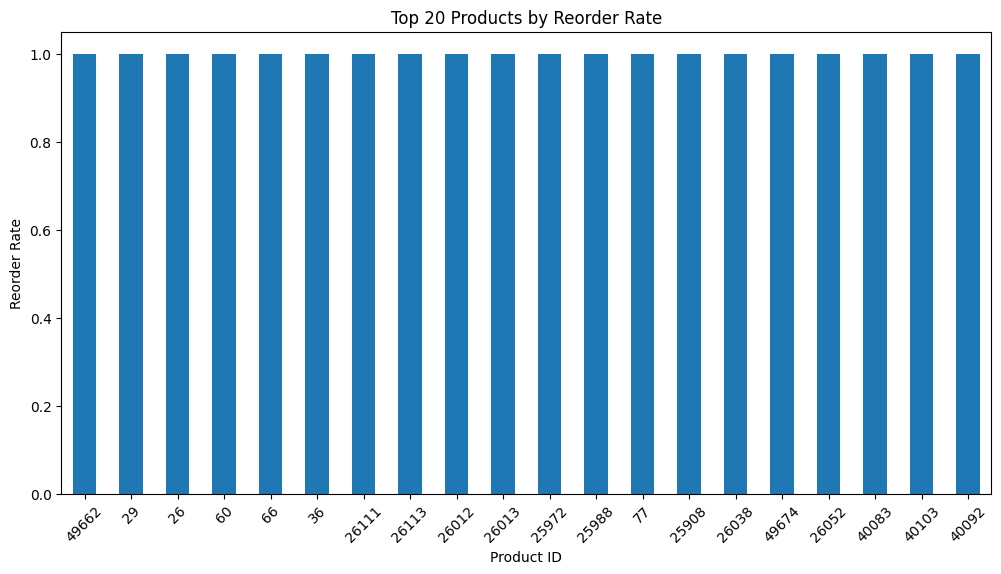

In [52]:
# Reorder rates by product ID
reorder_rates = final_retail_data.groupby('product_id')['reordered'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
reorder_rates.head(20).plot(kind='bar')
plt.title('Top 20 Products by Reorder Rate')
plt.xlabel('Product ID')
plt.ylabel('Reorder Rate')
plt.xticks(rotation=45)
plt.show()

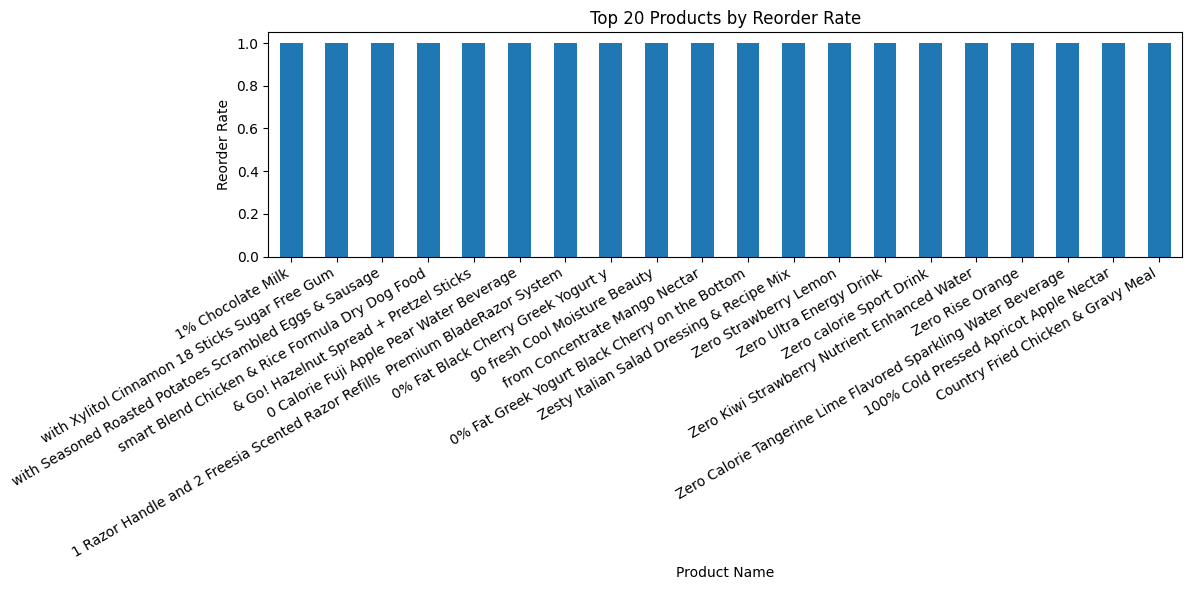

In [46]:
# Reorder rates by products_name
reorder_rates = final_retail_data.groupby('product_name_x')['reordered'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
reorder_rates.head(20).plot(kind='bar')

plt.title('Top 20 Products by Reorder Rate')
plt.xlabel('Product Name')
plt.ylabel('Reorder Rate')

plt.xticks(rotation=30, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

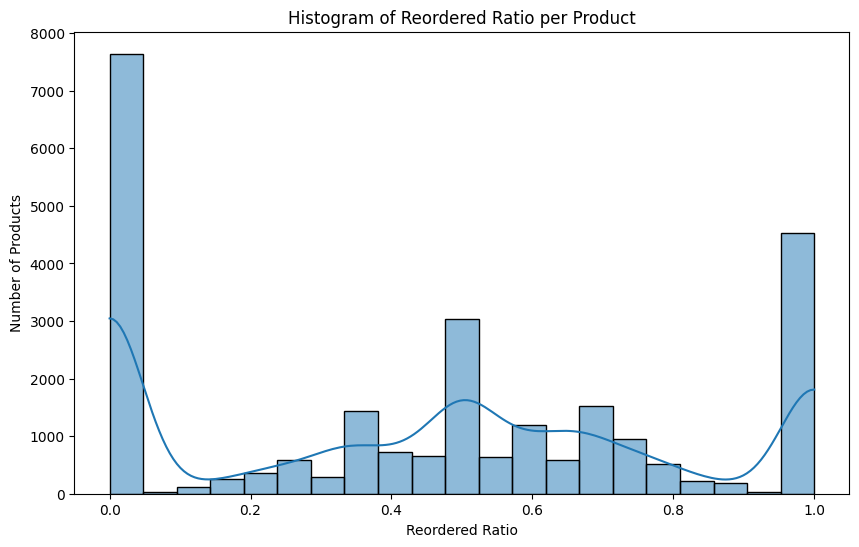

In [58]:
#  Histogram of reordered ratio per product
reorder_ratio = final_retail_data.groupby('product_id')['reordered'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(reorder_ratio, kde=True)
plt.title('Histogram of Reordered Ratio per Product')
plt.xlabel('Reordered Ratio')
plt.ylabel('Number of Products')
plt.show()

#Total number of orders by hours of the day And Day of the week

The total number of orders placed during a specific hour on a specific day of the week

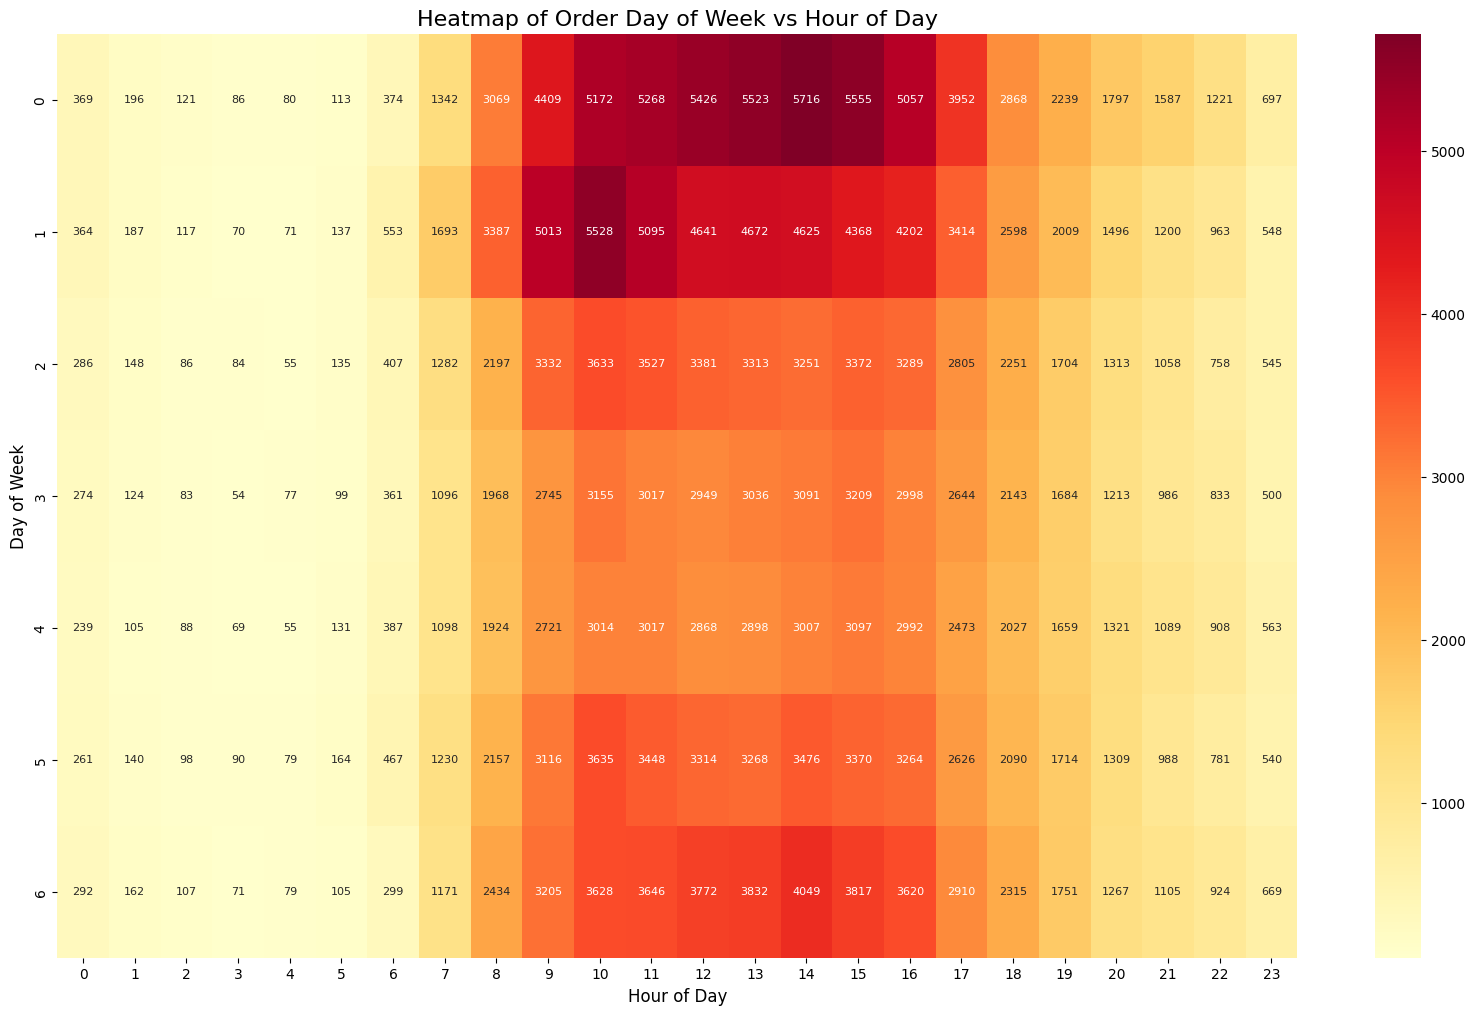

In [47]:
# Heatmap of order_dow vs order_hour_of_day
order_heatmap = pd.crosstab(final_retail_data['order_dow'], final_retail_data['order_hour_of_day'])
plt.figure(figsize=(20, 12))
sns.heatmap(order_heatmap, cmap='YlOrRd', annot=True, fmt='d', annot_kws={'size': 8})
plt.title('Heatmap of Order Day of Week vs Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

Interaction matrix shape: (118762, 25532)


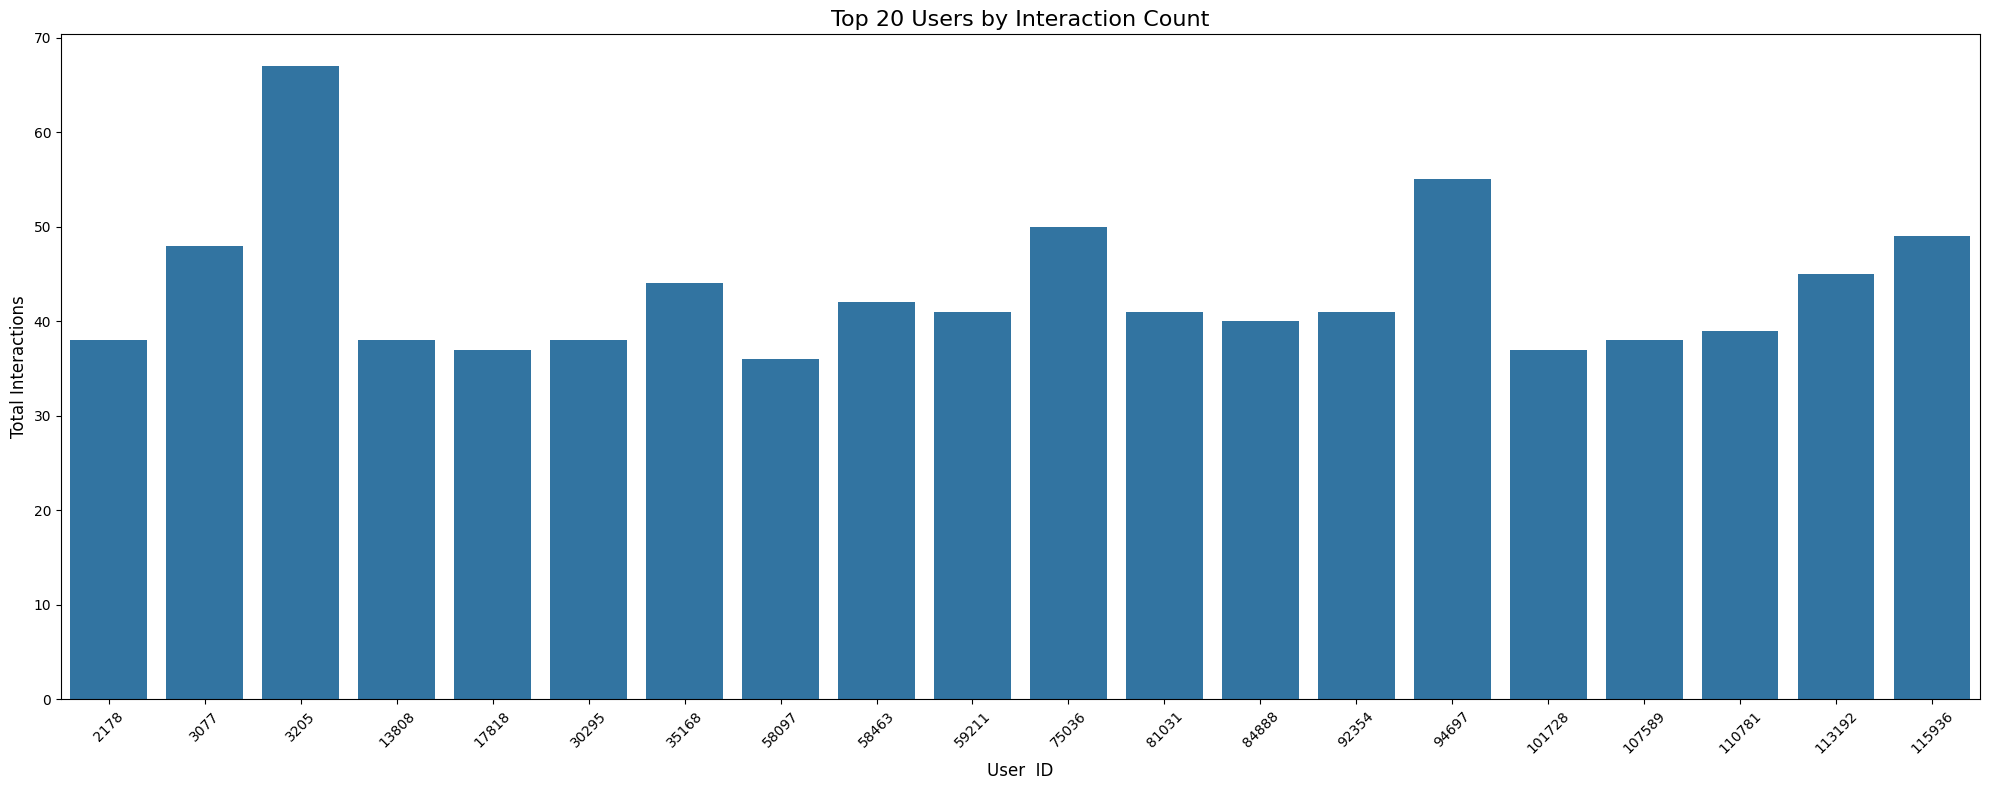

In [54]:
from scipy.sparse import csr_matrix

def create_sparse_interaction_matrix(df):
    users = df['user_id'].astype('category').cat.codes
    items = df['product_id'].astype('category').cat.codes
    interactions = df['interaction_count']

    return csr_matrix((interactions, (users, items)))

# Create the sparse interaction matrix from the final_retail_data
interaction_matrix = create_sparse_interaction_matrix(final_retail_data)

print("Interaction matrix shape:", interaction_matrix.shape)

def plot_top_users_bar(matrix, n_users=20):
    # Convert to dense array for summing
    user_totals = np.array(matrix.sum(axis=1)).flatten()

    # Get indices of top users
    top_users = np.argsort(user_totals)[-n_users:]

    # Create a subplot
    plt.figure(figsize=(20, 8))

    # Plot top users
    sns.barplot(x=top_users, y=user_totals[top_users])
    plt.title(f'Top {n_users} Users by Interaction Count', fontsize=16)
    plt.xlabel('User  ID', fontsize=12)
    plt.ylabel('Total Interactions', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()

# Plot the top users
plot_top_users_bar(interaction_matrix)

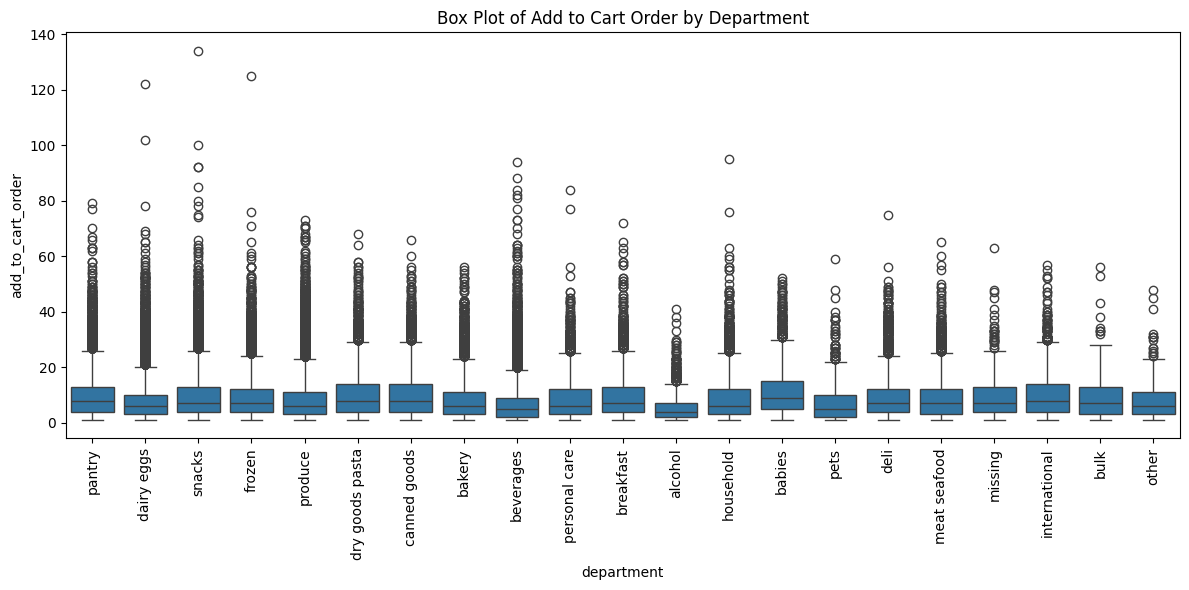

In [51]:
# Box plot of add_to_cart_order by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='add_to_cart_order', data=final_retail_data)
plt.title('Box Plot of Add to Cart Order by Department')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

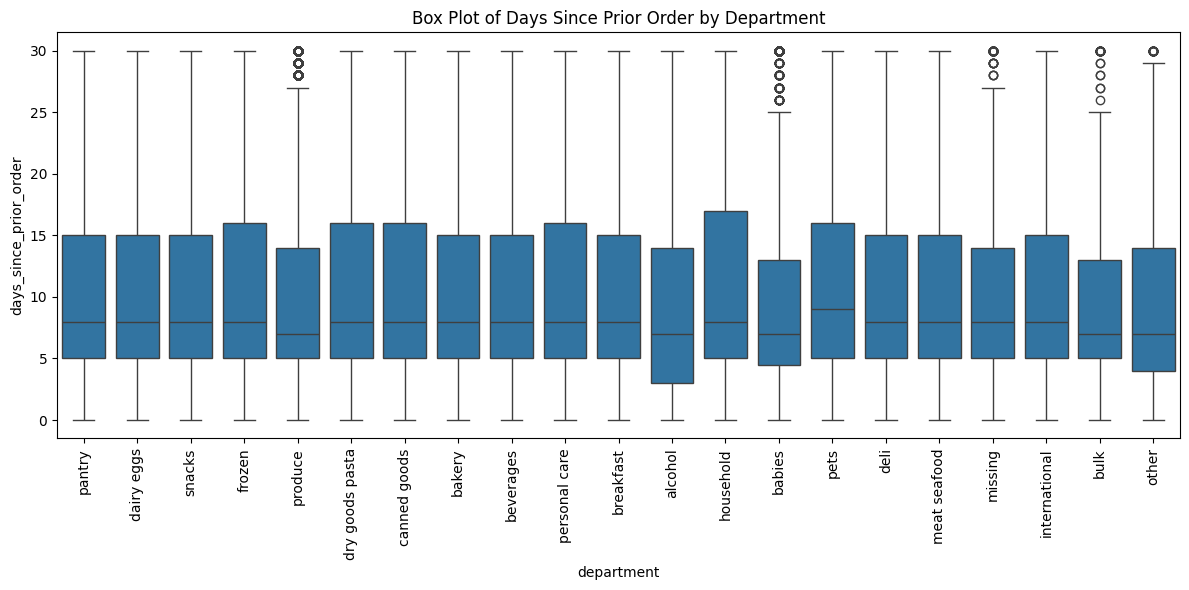

In [52]:
#  Box plot of days_since_prior_order by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='days_since_prior_order', data=final_retail_data)
plt.title('Box Plot of Days Since Prior Order by Department')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Top 5 Banana Buyers:
user_id
14552    16
5092      1
8843      1
10210     1
11917     1
Name: interaction_count, dtype: int64


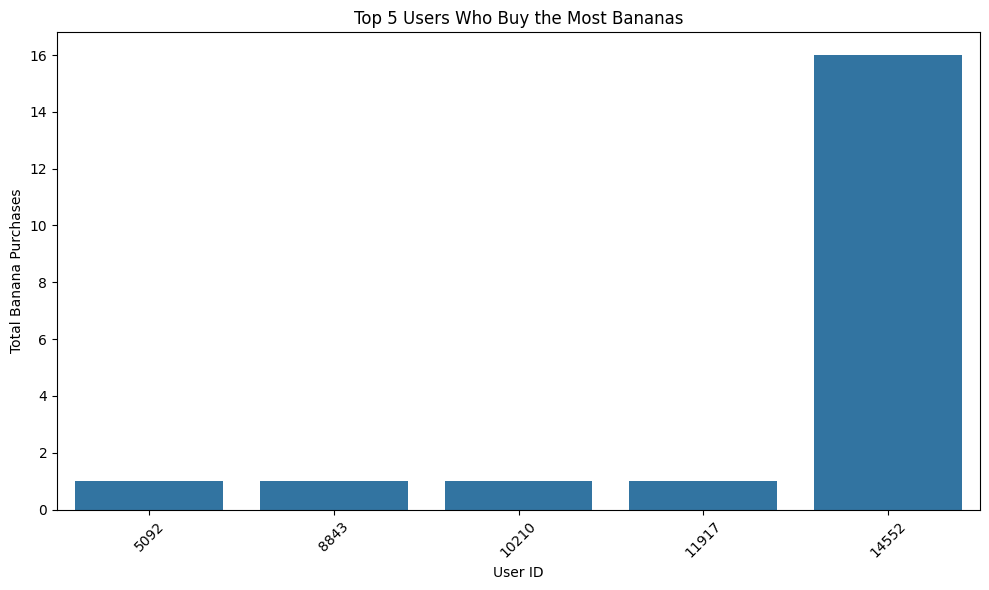

In [53]:
# Identify the top 5 users who buy the most "Bananas"
banana_buyers = final_retail_data[final_retail_data['product_name_x'] == 'Bananas']
top_banana_buyers = banana_buyers.groupby('user_id')['interaction_count'].sum().nlargest(5)

print("Top 5 Banana Buyers:")
print(top_banana_buyers)

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_banana_buyers.index, y=top_banana_buyers.values)
plt.title('Top 5 Users Who Buy the Most Bananas')
plt.xlabel('User ID')
plt.ylabel('Total Banana Purchases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



1. Added Three Columns


a) **interaction_count:**This column counts how many times each user-product
combination appears in the dataset. It helps with **identifying frequently purchased products for each user**.

b) **total_orders:** This column counts the unique orders for each user. It gives us an idea of **how active each user is on the platform**.

c) **product_order_rate:**  This is calculated as interaction_count / total_orders. **It represents the proportion of a user's orders that include a specific product, indicating how frequently a user buys a particular product relative to their overall purchasing behavior**.



2. **Visualized the  Dataset**


3. Identified the top 5 users who buy the most bananas by using there **User ID** and **Interaction-count**.


4. **NEXT STEPS**

We now need to determine the product recommended for these users based on their purchasing behavior




In [64]:
# Convert the DataFrame to a CSV file
final_retail_data.to_csv('final_retail_data.csv', index=False)